In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [3]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [4]:
def resnet50():
    return ResNet(Bottleneck, [3, 4, 6, 3], 10)

In [5]:
model = resnet50()

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')


Epoch 1, Loss: 1.7584540181014003
Epoch 2, Loss: 1.3330669688935182
Epoch 3, Loss: 1.0431514172529688
Epoch 4, Loss: 0.7974532772691882
Epoch 5, Loss: 0.619157109941755
Epoch 6, Loss: 0.479814849793911
Epoch 7, Loss: 0.3639536671796624
Epoch 8, Loss: 0.27053375861474444
Epoch 9, Loss: 0.19298867862291483
Epoch 10, Loss: 0.1536244165760522


In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 72.89%


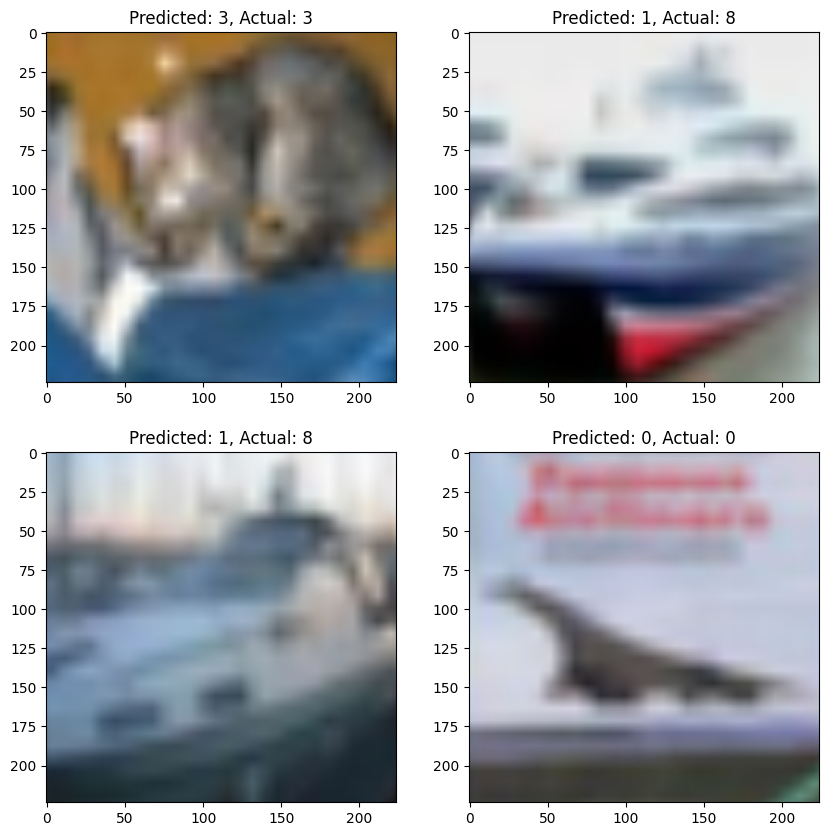

In [9]:
images, labels = next(iter(test_loader))
images = images[:4]
labels = labels[:4]

images = images.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)

predicted_labels = torch.argmax(outputs, dim=1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(len(images)):
    axs[i // 2, i % 2].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
    axs[i // 2, i % 2].set_title(f"Predicted: {predicted_labels[i].item()}, Actual: {labels[i].item()}")

plt.show()
